### CelebA CNN smile prediction and adversarial attacks (PDG and FGSM)
-Tanay Dangaich 

In [98]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [99]:
import torchvision 

from google.colab import drive
drive.mount('/content/drive')
image_path = '/content/drive/My Drive/Colab Notebooks/Data/'

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

get_smile = lambda attr: attr[31]

#celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', transform=transform, download=False,target_transform=get_smile)
#celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
#celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

#print('Train set:', len(celeba_train_dataset))
#print('Validation set:', len(celeba_valid_dataset))
#print('Test set:', len(celeba_test_dataset))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


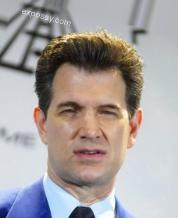

In [100]:
from IPython.display import Image
# Image(filename='/content/drive/My Drive/Colab Notebooks/Data/CelebA/celeba/img_align_celeba/000001.jpg', width=100)
Image(filename='/content/drive/My Drive/Colab Notebooks/Data/images/000015.jpg', width=100)

In [101]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.5)) 

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.5)) 

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())  
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 

model.add_module('flatten', nn.Flatten()) 
model.add_module('fc', nn.Linear(256, 1)) 
model.add_module('sigmoid', nn.Sigmoid()) 

In [102]:
epsilons = [0.01, 0.1]
pretrained_model = '/content/drive/My Drive/Colab Notebooks/models/celeba-cnn.ph'
use_cuda=True
example_image = '/content/drive/My Drive/Colab Notebooks/Data/images/000015.jpg'

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# device = torch.device("cuda")

model = model.to(device)
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model,map_location=device).state_dict())
model = model.to(device)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()
# from torch.utils.data import Subset
# from torch.utils.data import DataLoader
# celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(10))
# test_loader = DataLoader(celeba_train_dataset, batch_size=1, shuffle=False)
# image, target = next(iter(test_loader))
# print(image.shape)
# model(image.to(device))

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

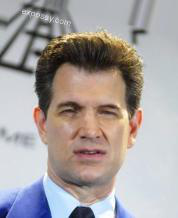

torch.Size([1, 3, 64, 64])


torch.Size([1, 1])

In [103]:
from PIL import Image
fp = open(example_image, 'rb')
img = Image.open(fp)
img.show()

#type(img)

img = transform(img)
img = img.unsqueeze(0);
print(img.shape)

# print('Image shape:', img.shape)
# print('Number of channels:', img.shape[0])
# print('Image data type:', img.dtype)
# print(img[:, 100:102, 100:102])

# image = torch.ones((4, 3, 64, 64))
# image = image.to(device)
# img =transform(img)
img = img.to(device)
# img.shape
model(img).shape

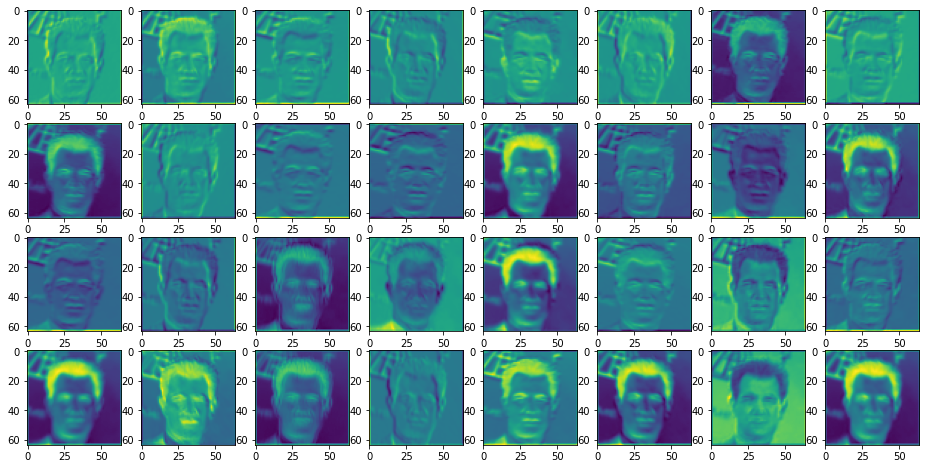

In [104]:
# Plot feature maps
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))

# First convolutional layer with 32 features
conv1 = model[0]
features1 = conv1(img)
for i in range(features1.size(1)):
    m = i//8
    j = i%8
    axs[m, j].imshow(features1[0, i].detach().cpu().numpy())

plt.show()

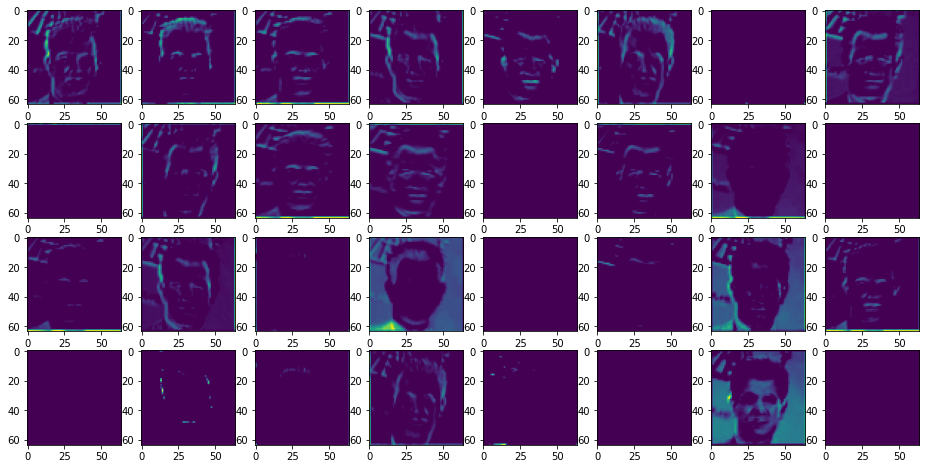

In [105]:
# Plot feature maps
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))

# First ReLU layer with 32 features
relu1 = model[1]
features2 = relu1(features1)
for i in range(features2.size(1)):
    m = i//8
    j = i%8
    axs[m, j].imshow(features2[0, i].detach().cpu().numpy())

plt.show()

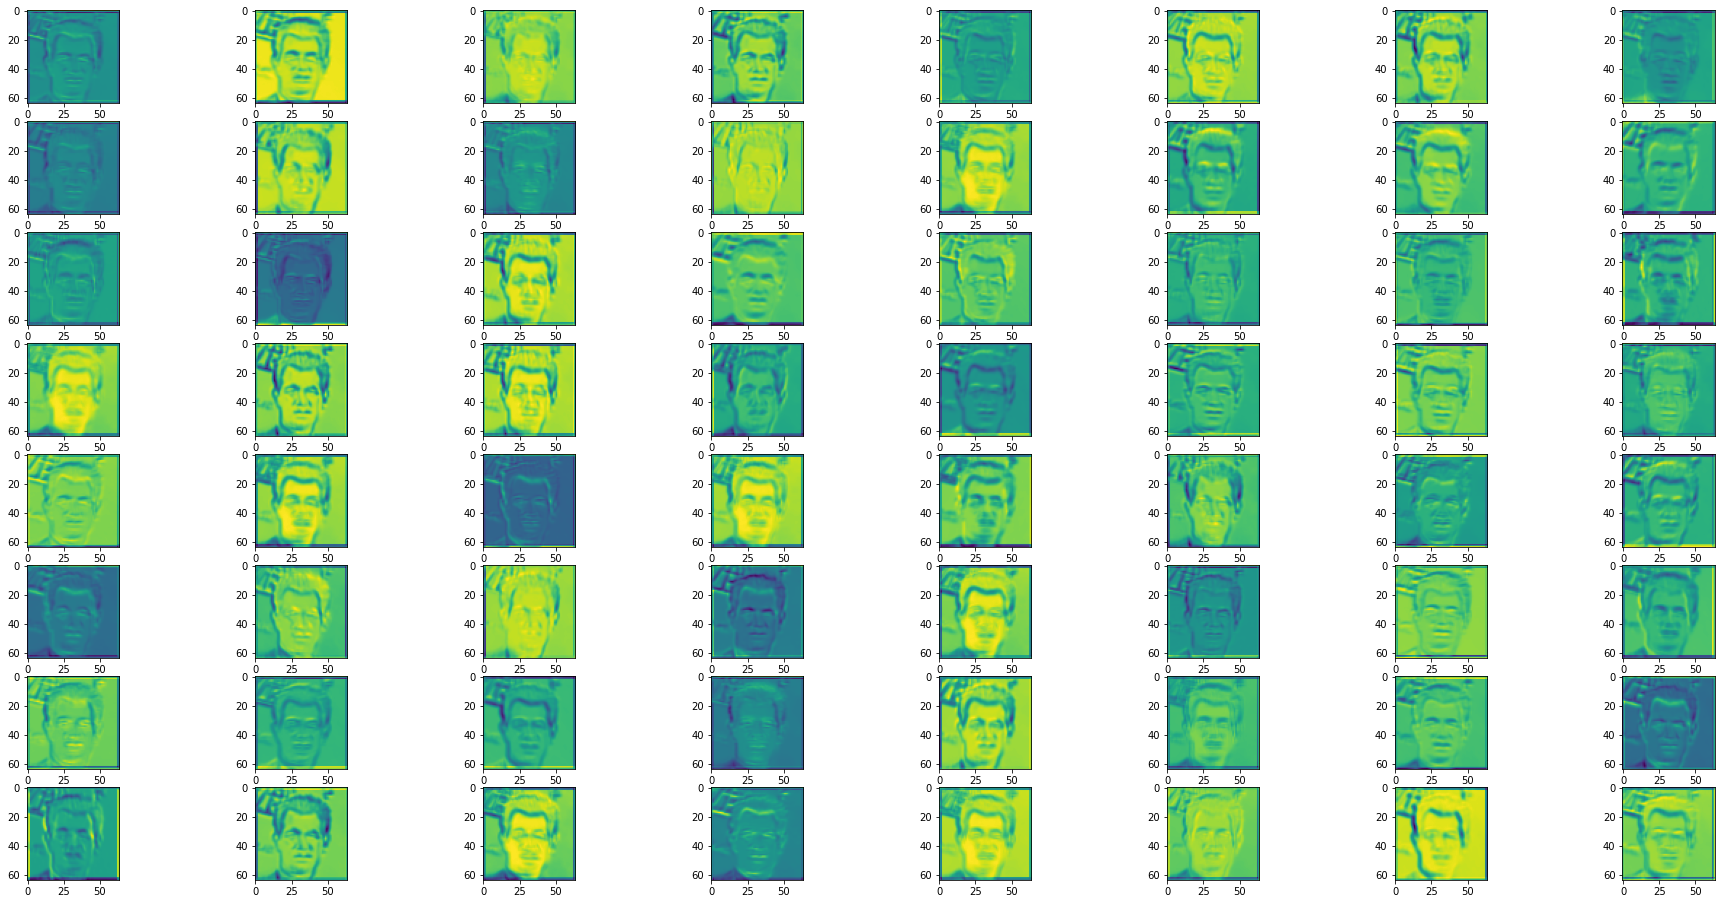

In [106]:
# Plot feature maps
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(32, 16))

# Second convolutional layer with 64 features
conv2 = model[4]
features3 = conv2(features2)
for i in range(features3.size(1)):
    m = i//8
    j = i%8
    axs[m, j].imshow(features3[0, i].detach().cpu().numpy())

plt.show()

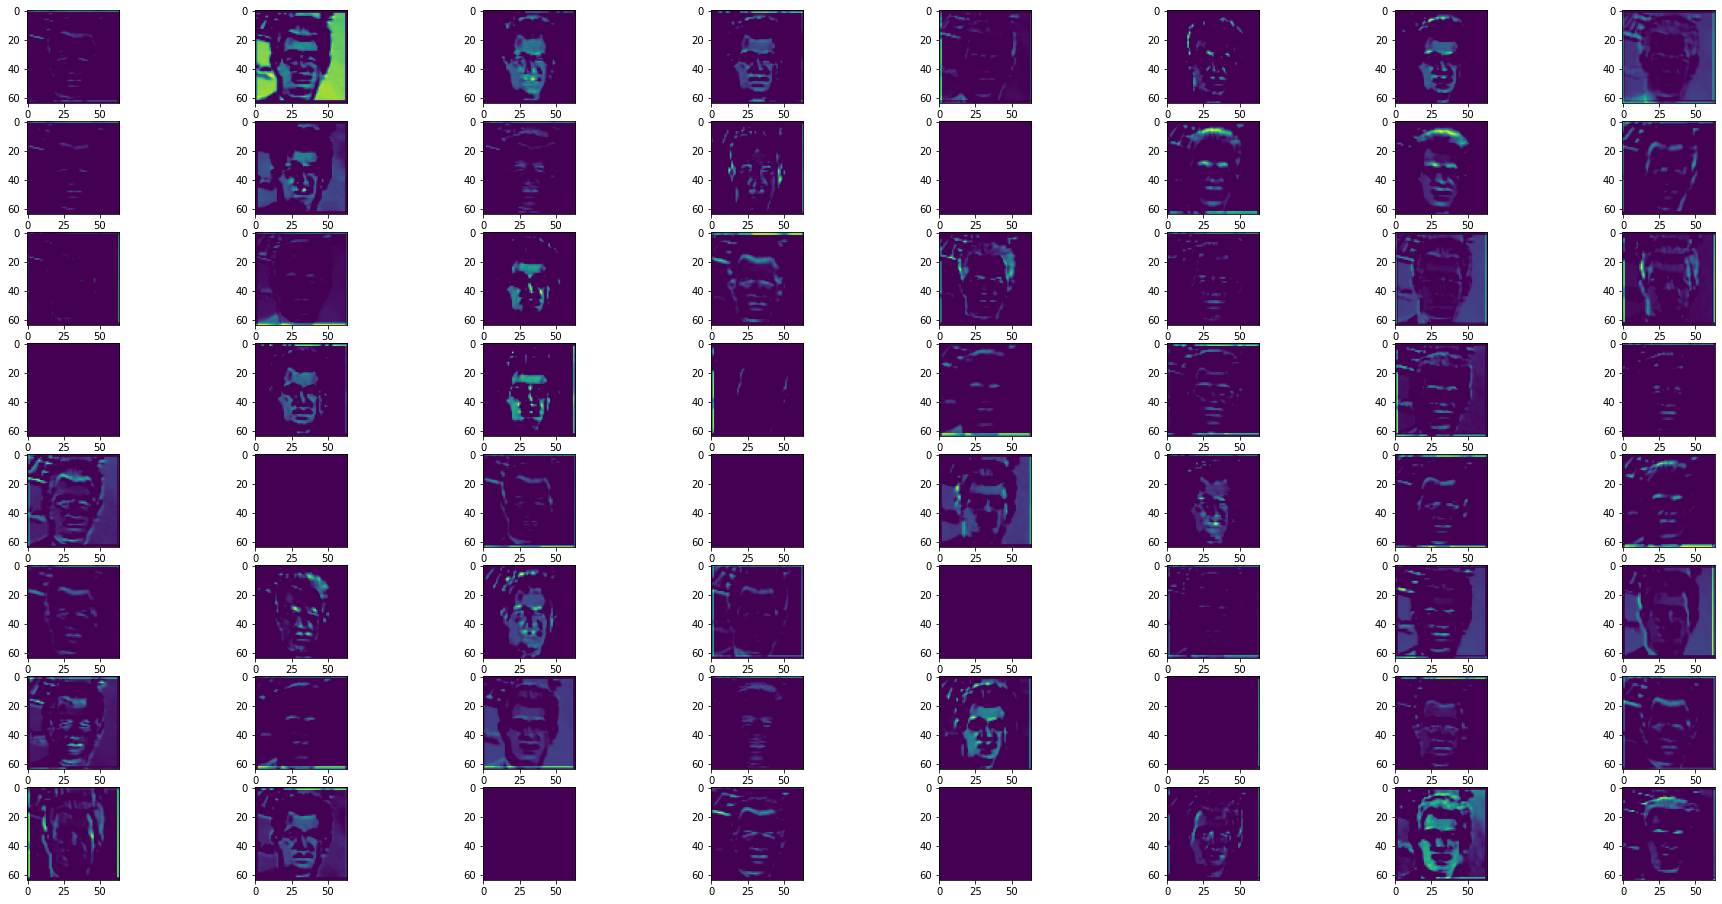

In [107]:
# Plot feature maps
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(32, 16))

# Second ReLU layer with 64 features
relu2 = model[5]
features4 = relu2(features3)
for i in range(features4.size(1)):
    m = i//8
    j = i%8
    axs[m, j].imshow(features4[0, i].detach().cpu().numpy())

plt.show()

In [108]:
def pgd_attack(model, images, labels, eps=0.3, alpha=1/255, iters=20) :
    #images = images.to(device)
    #labels = labels.to(device)
    loss = nn.BCELoss()
    #print(images.shape)
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        outputs= outputs.squeeze(1)
        #print("output {} label {}".format(outputs.data,labels.data))
        #print(outputs.dtype)
        #print(labels.dtype)
        cost = loss(outputs, labels)
        
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        #print(images.shape)
            
    return images

In [109]:
# Defining FGSM Attack function
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [110]:
# Performing FGSM Attack
criteria = nn.BCELoss()
predicted = []
ground_truth = [0, 1, 1, 1, 0] # Assuming
perturbed_pred = []
perturbed_image = []
# drive.mount('/content/drive')
image_path = '/content/drive/My Drive/Colab Notebooks/Data/'
dataset = datasets.ImageFolder(root = image_path, transform=transform)

for data, _ in dataset:
  data = data.float().to(device)
  data.unsqueeze_(0)
  data.requires_grad = True
  output = model(data.float())
  
  actual = output.round() # Assuming model predictions are right!

  print('Actual Predictions: {}'.format(int(actual.item())))

  predicted.append(actual.item())
  
  loss = criteria(output, actual)
  
  model.zero_grad()
  
  loss.backward()
  
  data_grad = data.grad.data

  epsilon = 0.0515

  perturbed_data = fgsm_attack(data, epsilon, data_grad)

  output_perturbed = model(perturbed_data)

  perturbed_pred.append(output_perturbed.round().item())

  perturbed_image.append(perturbed_data)

  print('Model Predictions on Perturbed data: {}'.format(int(output_perturbed.round().item())))


Actual Predictions: 0
Model Predictions on Perturbed data: 1
Actual Predictions: 1
Model Predictions on Perturbed data: 0
Actual Predictions: 1
Model Predictions on Perturbed data: 0
Actual Predictions: 1
Model Predictions on Perturbed data: 0
Actual Predictions: 0
Model Predictions on Perturbed data: 1


In [111]:
# Evaluating Model
model.eval()
model.zero_grad()
for val in range(len(dataset)):
    output = model(dataset[val][0].float().unsqueeze_(0).to(device))
    print('Probability of Smiling: {}'.format(round(output.item(), 2)))
    print('Label for Smile: {}'.format(output.round().item()))

Probability of Smiling: 0.07
Label for Smile: 0.0
Probability of Smiling: 0.61
Label for Smile: 1.0
Probability of Smiling: 0.99
Label for Smile: 1.0
Probability of Smiling: 1.0
Label for Smile: 1.0
Probability of Smiling: 0.03
Label for Smile: 0.0


# Checking Predictions on Original Images

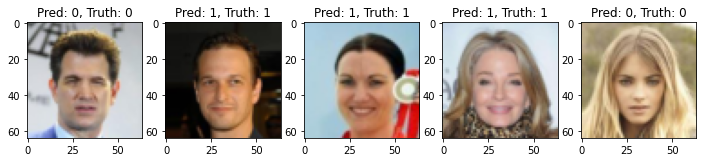

In [112]:
uf, axarr = plt.subplots(1,5, figsize=(12,9))
count = 0 
for img, _ in dataset:
  try:
    axarr[count].imshow(img.permute(1, 2, 0))
    axarr[count].set_title('Pred: {}, Truth: {}'.format(int(predicted[count]), int(ground_truth[count])))
    count = count + 1
  except:
    pass

# Checking Predictions on Adversarial Images

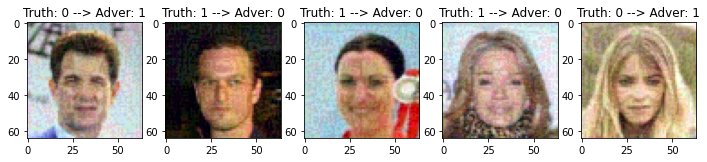

In [113]:
f, axarr = plt.subplots(1,5, figsize=(12,9))
count = 0 
for img in perturbed_image:
    img = torch.squeeze(img)
    img = img.to(device)
    axarr[count].imshow(img.permute(1, 2, 0).detach().cpu().numpy())
    axarr[count].set_title('Truth: {} --> Adver: {}'.format(int(ground_truth[count]), int(perturbed_pred[count])))
    count = count + 1